Este archivo es para implementar algunos algoritmos de aprendizaje por refuerzo y aplicarlos utilizando Open AI gym.

Se van a probar los siguientes 2 entornos (environments), de acuerdo con los resultados presentados en el articulo de Diego:

Pendulum-v0 y Hopper-v2

Tareas (Puede cambiar):
1. Terminar el curso de David Silver. (Completo: 100%)
2. Implementar con table lookup. (En progreso: Ya medio funciona (por ahi un 80%))
3. Implementar con DQN. (Sin comenzar)
4. Implementar con Simglucose (Sin comenzar)
5. Implementar con el trabajo de Diego.

# Librerías

In [2]:
import gym
import time
import numpy as np
import progressbar

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers

%matplotlib inline
import matplotlib.pyplot as plt

Using TensorFlow backend.


# Clases

In [32]:
class ExperienceReplay():
    def __init__(self, tamano_minimo = 1000, tamano_maximo = 10**6, tamano_batch = 32):
        self.tamano_buffer = 0
        self.tamano_batch = tamano_batch
        self.tamano_minimo = tamano_minimo
        self.tamano_maximo = tamano_maximo
        self.buffer = np.empty(1)
        
    def agregarDato(self, x, a, r, xp):
        dato = dict({'St':x, 'At':a, 'Rt+1':r, 'St+1':xp})
        
        if(self.tamano_buffer == 0):
            self.buffer = np.append(self.buffer, dato)
            self.buffer = np.delete(self.buffer, 0)
            self.tamano_buffer = 1
        else:
            self.buffer = np.append(self.buffer, dato)
            self.tamano_buffer += 1
        
        if(self.tamano_buffer > self.tamano_maximo):
            self.buffer = np.delete(self.buffer, 0)
            self.tamano_buffer -= 1
            
    
    def darMuestras(self):
        indices = np.random.choice(range(self.tamano_buffer), size = self.tamano_batch, replace = False)
        return self.buffer[indices]

In [63]:
test = np.array([dict({'A':0,
              'B':1}) 
        for i in range(10)])
test2 = np.empty(1)
indices = np.random.choice(range(10), size = 5, replace = False)
print(indices)
print(test[indices])

test3 = np.append(test2, dict({'A':1, 'B':3}))

[9 7 3 6 5]
[{'A': 0, 'B': 1} {'A': 0, 'B': 1} {'A': 0, 'B': 1} {'A': 0, 'B': 1}
 {'A': 0, 'B': 1}]


In [66]:
test3

array([{'A': 1, 'B': 3}], dtype=object)

# Table Lookup

Pendulum-v0<br /> 
Utilizando el algoritmo de Sarsa.<br />
Está como chambón pero funciona.

In [ ]:
def darIndice(pS):
    return int(round(pS, 1)*10+10)

def escogerAccion(pS1, pS2, pS3):
    num = np.random.random()
    
    if(num <= epsilon):
        ind = np.random.randint(0,41)
        return ind
    else:
        ind = np.where(tablaQ[pS1, pS2, pS3, :] == np.amax(tablaQ[pS1, pS2, pS3, :]))
        ind = ind[0]
        
        if(len(ind) > 1):
            return np.random.choice(ind)
        else:
            return ind
    
    return accion

In [ ]:
envName = 'Pendulum-v0'

g = 0.9
alpha = 0.5
epsilon = 0.1 #Entre 0 y 1
maxIter = 1500000
ventana = 100
epsilonIterLimit = maxIter*0.9

tablaQ = np.ones((21,21,17,41))*-16
rewards = np.zeros(int(maxIter/10))

env = gym.make(envName)
observation = env.reset()

s1 = darIndice(observation[0])
s2 = darIndice(observation[1])
s3 = int(round(observation[2], 0) + 8)
a = escogerAccion(s1, s2, s3)

suma = 0

for i in progressbar.progressbar(range(maxIter)):
    
    if(i > maxIter-2000):
        env.render()
    
    observation, reward, done, info = env.step([(a-20)/10.0])
    observation = np.reshape(observation, (3,))
    
    s1p = darIndice(observation[0])
    s2p = darIndice(observation[1])
    s3p = int(round(observation[2], 0) + 8)
    
    ap = escogerAccion(s1p, s2p, s3p)
    
    r = reward #Por ahora
    suma+=r
    
    if(i % ventana == 0):
        rewards[int(i/ventana)] = suma/ventana
        suma = 0
    
    tablaQ[s1, s2, s3, a] = tablaQ[s1, s2, s3, a] + alpha*(r + g*tablaQ[s1p, s2p, s3p, ap] - tablaQ[s1,s2,s3,a])
    
    s1 = s1p
    s2 = s2p
    s3 = s3p
    a = ap
    
    if(i > epsilonIterLimit):
        epsilon = 0
    
env.close()

In [ ]:
for i in progressbar.progressbar(range(2000)):
    env.render()
    
    observation, reward, done, info = env.step([(a-20)/10.0])
    observation = np.reshape(observation, (3,))
    
    s1p = darIndice(observation[0])
    s2p = darIndice(observation[1])
    s3p = int(round(observation[2], 0) + 8)
    
    ap = escogerAccion(s1p, s2p, s3p)
    
    r = reward #Por ahora
    suma+=r
    
    if(i % ventana == 0):
        rewards[int(i/ventana)] = suma/ventana
        suma = 0
    
    tablaQ[s1, s2, s3, a] = tablaQ[s1, s2, s3, a] + alpha*(r + g*tablaQ[s1p, s2p, s3p, ap] - tablaQ[s1,s2,s3,a])
    
    s1 = s1p
    s2 = s2p
    s3 = s3p
    a = ap
    
env.close()

# DQN

In [43]:
#Creando red neuronal
def crearModelo(n1 = 20, n2 = 41, learning_rate = 0.01):
    modelo = Sequential()
    
    modelo.add(Dense(n1, activation = 'relu', input_dim = 3))
    modelo.add(Dense(n2, activation = 'linear'))
    
    sgd = optimizers.sgd(lr = learning_rate)
    
    modelo.compile(loss = 'mean_squared_error', optimizer = sgd, metrics = ['accuracy'])
    
    return modelo

def escogerAccion(pModelo, pX):
    num = np.random.random()
    
    if(num <= epsilon):
        ind = np.random.randint(0,41)
        return ind
    else:
        ind = np.argmax(pModelo.predict(pX))
        return ind

In [ ]:
envName = 'Pendulum-v0'

modelo = crearModelo(learning_rate = 0.001)

#Con los parametros default.
buffer = ExperienceReplay()

gamma = 0.99
alpha = 0.35
epsilon = 1#Entre 0 y 1
epsilonDecay = 0.95

episodes = 300
stepsPrueba = 1000
maxSteps = 150
ventana = 100
contadores = np.zeros((1,41))

rewardsAcumulados = np.zeros(episodes)

env = gym.make(envName)
observation = env.reset()

x = np.reshape(observation, (1,3))
x[0,2] = x[0,2]/8.0

a = escogerAccion(modelo, x)

#Este es un for inicial donde se almacena la cantidad minima de datos requerida en el buffer
#antes de comenzar con el entrenamiento.
for i in progressbar.progressbar(range(buffer.tamano_minimo)):
    observation, reward, done, info = env.step([(a-20.0)/10.0])
    
    xp = np.reshape(observation, (1,3))
    xp[0,2] = xp[0,2]/8.0
    x = xp
    
    buffer.agregarDato(x, a, reward, xp)
    
    #epsilon es 1 asi que siempre va a escoger al azar.
    a = escogerAccion(modelo, x)
    
for e in progressbar.progressbar(range(episodes)):
    rewardAcumulado = 0
    env = gym.make(envName)
    observation = env.reset()
    x = np.reshape(observation, (1,3))
    x[0,2] = x[0,2]/8.0
    a = escogerAccion(modelo, x)
    
    for s in range(maxSteps):
        observation, reward, done, info = env.step([(a-20.0)/10.0])
        
        rewardAcumulado += reward
        
        xp = observation
        xp = np.reshape(xp, (1,3))
        xp[0,2] = xp[0,2]/8.0

        buffer.agregarDato(x, a, reward, xp)

        muestras = buffer.darMuestras()

        #Pasar esto a un metodo solito
        xEnt = np.empty((1,3))
        aEnt = np.empty(1)
        rEnt = np.empty(1)
        xpEnt = np.empty((1,3))

        for m in muestras:
            xEnt = np.append(xEnt, m.get('St'), axis = 0)
            aEnt = np.append(aEnt, [m.get('At')], axis = 0)
            rEnt = np.append(rEnt, [m.get('Rt+1')], axis = 0)
            xpEnt = np.append(xpEnt, m.get('St+1'), axis = 0)

        xEnt = np.delete(xEnt, 0, axis = 0)
        aEnt = np.delete(aEnt, 0, axis = 0)
        rEnt = np.delete(rEnt, 0, axis = 0)
        xpEnt = np.delete(xpEnt, 0, axis = 0)

        qValores = modelo.predict(xEnt)

        maxQvalores = np.amax(qValores, axis = 1)

        #Aqui hay que calcular el maximo
        targets = np.add(rEnt, gamma*maxQvalores)

        yEnt = modelo.predict(xEnt)

        for j in range(buffer.tamano_batch):
            yEnt[j,int(aEnt[j])] = targets[j]

        modelo.fit(xEnt, yEnt, verbose = 0)

        x = xp
        a = escogerAccion(modelo, x)

    epsilon = epsilon*epsilonDecay
    rewardsAcumulados[e] = rewardAcumulado

env = gym.make(envName)
observation = env.reset()
x = np.reshape(observation, (1,3))
x[0,2] = x[0,2]/8.0
a = escogerAccion(modelo, x)    
    
for s in range(stepsPrueba):
    
    observation, reward, done, info = env.step([(a-20.0)/10.0])
    
    env.render()
    
    xp = observation
    xp = np.reshape(xp, (1,3))
    xp[0,2] = xp[0,2]/8.0
    
    a = escogerAccion(modelo, xp)
    
env.close()

100% (1000 of 1000) |####################| Elapsed Time: 0:00:00 Time:  0:00:00
 52% (157 of 300) |###########           | Elapsed Time: 0:02:08 ETA:   0:03:01

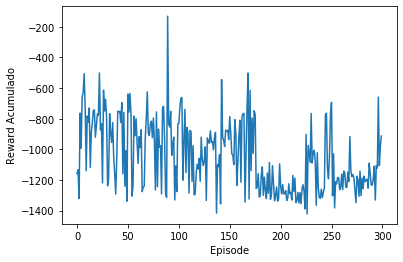

In [42]:
plt.plot(rewardsAcumulados)
plt.xlabel('Episode')
plt.ylabel('Reward Acumulado')
plt.show()

In [50]:
stepsPrueba = 100

env = gym.make(envName)
observation = env.reset()
x = np.reshape(observation, (1,3))
x[0,2] = x[0,2]#/8.0
a = escogerAccion(modelo, x)    
    
for s in range(stepsPrueba):
    
    observation, reward, done, info = env.step([(a-20.0)/10.0])
    
    env.render()
    
    xp = observation
    xp = np.reshape(xp, (1,3))
    xp[0,2] = xp[0,2]#/8.0
    
    a = escogerAccion(modelo, xp)
    
env.close()

In [48]:
x[0,2]

-0.7495898333002571

In [159]:
aEnt.shape

(2,)

In [6]:
contadores

array([[ 618.,  266.,  253.,  333., 1241.,  345.,  308.,  830., 1303.,
         797.,  452.,  332.,  983.,  149.,  362.,  178., 3307.,  268.,
         438., 1041.,  542.,  413.,  586.,  630.,  830.,  494.,  925.,
        1385., 1835.,  428.,  368.,  713.,  669.,  751., 1593.,  508.,
         770., 1066.,  255., 1183.,  252.]])

In [21]:
0.9999**50000

0.006736262610603238

In [ ]:
import gym
env = gym.make('Pendulum-v0')
for i_episode in range(20):
    observation = env.reset()
    for t in range(10):
        env.render()
        print(observation)
        action = env.action_space.sample()
        observation, reward, done, info = env.step(action)
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            break
env.close()

In [ ]:
print(env.observation_space)
print(env.action_space)

In [ ]:
print(env.observation_space.high)
print(env.observation_space.low)

In [ ]:
np.random.random()

In [ ]:
np.random.randint(0,6)

In [ ]:
test = np.array([10,22,50,-1,50])

In [ ]:
test3 = np.where(test == np.amax(test))

In [ ]:
len(test3[0])

In [ ]:
rewards[10/10]

In [43]:
rewards[300]

0.0

In [58]:
buffer.tamano_buffer

2000